In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import dgl
import torch
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
labels_df  = pd.read_csv('SS-Butterfly_labels.tsv', sep='\t')
weights_df  = pd.read_csv('SS-Butterfly_weights.tsv', sep='\t')

FileNotFoundError: ignored

In [ ]:
labels_df.rename(columns={'# Node_ID': 'node_id', 'Species' : 'species'}, inplace=True)
weights_df.rename(columns={'# NodeID1': 'node_id1', 'NodeID2' : 'node_id2', 'Image similarity weight' : 'image_similarity_weight'}, inplace=True)

In [ ]:
node_ids = labels_df['node_id'].tolist()
nodes = dgl.graph([], num_nodes=len(node_ids), device='cpu')

node_labels = labels_df['species'].tolist()
nodes.ndata['species'] = torch.tensor(node_labels)

src_ids = weights_df['node_id1'].tolist()
dst_ids = weights_df['node_id2'].tolist()
edges = list(zip(src_ids, dst_ids))

edge_weights = weights_df['image_similarity_weight'].tolist()
edge_weights = torch.tensor(edge_weights)

graph = dgl.heterograph({
    ('node', 'edge', 'node'): edges
}, {'node': len(node_ids)})

graph.edges['edge'].data['weight'] = edge_weights

graph.ndata['species'] = torch.tensor(labels_df['species'].tolist())

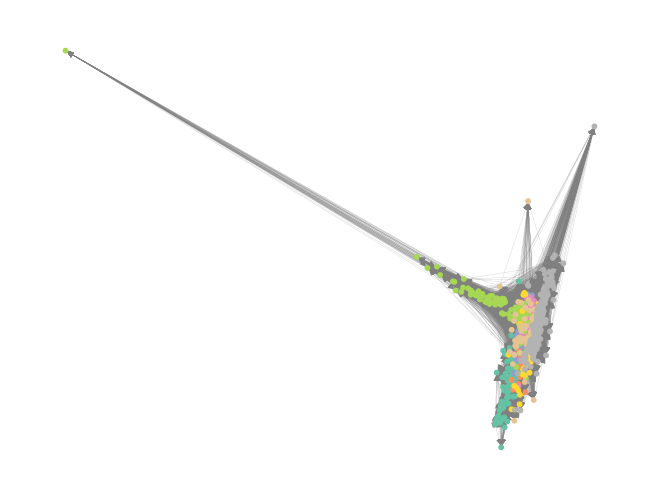

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = graph.to_networkx(node_attrs=['species'])
pos = nx.spring_layout(nx_graph)
node_colors = nodes.ndata['species'].tolist()

nx.draw(nx_graph, pos=pos, node_size=10, width=0.1, edge_color='grey', node_color=node_colors, cmap='Set2')
plt.show()


In [ ]:
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.linear1 = nn.Linear(in_feats, hidden_feats)
        self.conv1 = GraphConv(hidden_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, out_feats)
        
    def forward(self, g, features):
        x = F.relu(self.linear1(features))
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
graph = dgl.add_self_loop(graph)